# Companies House Example

Install and import all dependencies.

In [18]:
%pip install svgpath2mpl
%pip install svgpathtools
%pip install pyvis

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 14.9 MB/s eta 0:00:0000:01
  Using cached jsonpickle-3.0.1-py2.py3-none-any.whl (40 kB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached MarkupSafe-2.1.2-cp310-cp310-macosx_10_9_universal2.whl (17 kB)
Note: you may need to restart the kernel to use updated packages.


In [20]:
import pandas as pd
import csv
import time
import json
import matplotlib.pyplot as plt
import seaborn as sns

Import CSV file and create your graph by adding the edges you would like.

In [116]:
from raphtory import Graph
from raphtory import algorithms

g = Graph()

file = "/tmp/finaldf.csv"
with open(file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter = ',')
    line_count = 0
    for row in csv_reader:
        psc1 = row[0]
        psc2 = row[3]
        company_number = str(row[2].replace("'", ""))
        time = int(row[1])
        g.add_edge(time, psc1, company_number, {})
        # g.add_edge(time, psc2, company_number, {})
        g.add_edge(time, psc1, psc2, {})
        line_count += 1
    print(f'Processed {line_count} lines.')

Processed 572 lines.


Use the draw() function to visualise your graph.

TypeError: GraphView.edges() takes no keyword arguments

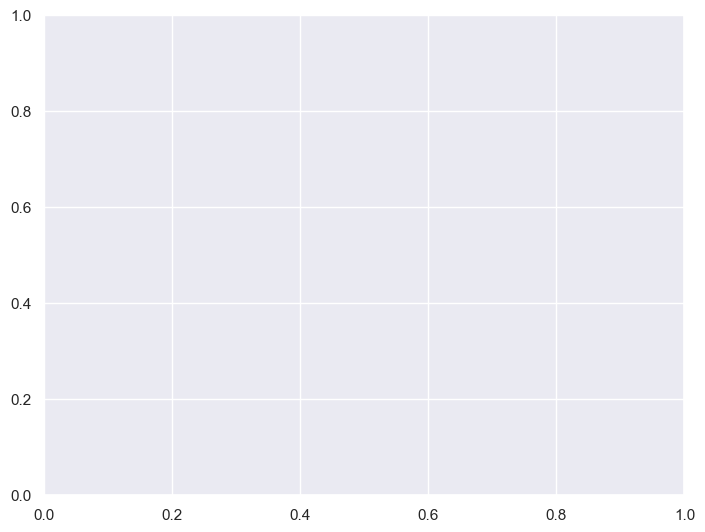

In [117]:
from raphtory import plot
from svgpathtools import svg2paths
from svgpath2mpl import parse_path
import matplotlib as mpl

company_man_path, attributes = svg2paths('company_man.svg')
company_man_marker = parse_path(attributes[0]['d'])
company_man_marker.vertices -= company_man_marker.vertices.mean(axis=0)
company_man_marker = company_man_marker.transformed(mpl.transforms.Affine2D().rotate_deg(180))
company_man_marker = company_man_marker.transformed(mpl.transforms.Affine2D().scale(-1,1))   

view = g.at(1645639200000)
plot.draw(view, with_labels=False, marker=company_man_marker)

In [65]:
df = pd.read_json('/tmp/psctopsc.json')
df


,source,target,Share_Ownership,Date
0,Derek-Patrick-Bernard-Cameron-11-1938,Scotmas-Group-Ltd-00,75,2016-04-06
1,Salween-Investments-Limited-00,Jamie-Robert-Cooke-3-1981,25,2021-03-01
2,Karen-Jane-Steven-7-1985,Simon-Steven-11-1979,0,2016-09-23
3,Karen-Jane-Steven-7-1985,Andrea-Jane-Steven-10-1988,0,2016-09-23
4,Karen-Jane-Steven-7-1985,Arthur-Michael-Steven-8-1949,0,2016-09-23
...,...,...,...,...
329,Jamie-Robert-Cooke-3-1981,Stratificatus-Limited-00,25,2016-09-28
330,Nicholas-Hamish-Thomson-3-1968,Bell-&-Bain-(Holdings)-Limited-00,75,2016-04-06
331,Ian-Mckenzie-6-1968,Correct-Solutions-(Scotland)-Limited-00,75,2019-03-21
332,Alison-Jane-Donnelly-3-1976,Jamie-Robert-Cooke-3-1981,0,2021-03-01


In [82]:
nhs_csv = pd.read_csv('/tmp/filter.csv')
nhs_csv.drop(columns=nhs_csv.columns[0], axis=1, inplace=True)
nhs_csv


,notified_on,window,psc,company,ownership_percentage,date_awarded,award_value,contract_awarded_in_epoch,total_contract_value
0,2016-04-07,P1D,Craig-Robertson-5-1985,SC260789,25,2020-03-16,350000.0,1.584317e+09,2.092560e+06
1,2016-04-07,P1D,Craig-Robertson-5-1985,SC260789,25,2021-01-19,347520.0,1.611014e+09,2.092560e+06
2,2016-04-07,P1D,Ian-Robertson-6-1959,SC260789,25,2020-03-16,350000.0,1.584317e+09,2.092560e+06
3,2016-04-07,P1D,Ian-Robertson-6-1959,SC260789,25,2021-01-19,347520.0,1.611014e+09,2.092560e+06
4,2022-01-26,P1D,Cr24-Ltd-00,SC260789,75,2020-03-16,350000.0,1.584317e+09,2.092560e+06
...,...,...,...,...,...,...,...,...,...
868,2021-03-11,P1D,Deloitte-Nse-No3-Limited-00,OC303675,0,2020-08-17,87500.0,1.597622e+09,1.042219e+09
869,2021-03-11,P1D,Deloitte-Nse-No3-Limited-00,OC303675,0,2021-10-07,56638.0,1.633565e+09,1.042219e+09
870,2021-03-11,P1D,Deloitte-Nse-No3-Limited-00,OC303675,0,2020-05-04,42000.0,1.588550e+09,1.042219e+09
871,2021-03-11,P1D,Deloitte-Nse-No3-Limited-00,OC303675,0,2020-04-20,24800.0,1.587341e+09,1.042219e+09


In [79]:
pscs = pd.read_csv('/tmp/finaldf.csv', names=["psc", "time", "company", "other_psc", "out_edges"])
pscs1 = pscs.dropna()
pscs1['time'] = pd.to_datetime(pscs1['time'], unit='ms')
pscs1

,psc,time,company,other_psc,out_edges
0,Claire-Selina-Carter-3-1966,2016-04-06 18:00:00,OC374799,George-Robert-Carter-5-1964,2
1,George-Robert-Carter-5-1964,2018-01-11 18:00:00,11145134,Claire-Selina-Carter-3-1966,2
2,Simon-Steven-11-1979,2016-09-23 18:00:00,SC546140,Arthur-Michael-Steven-8-1949,1
3,Simon-Steven-11-1979,2016-09-23 18:00:00,SC546140,Elizabeth-Grace-Steven-9-1948,1
4,Geralyn-Wilson-10-1954,2016-09-20 18:00:00,10385281,Fiona-Mary-Bowers-2-1972,1
...,...,...,...,...,...
567,Jamie-Robert-Cooke-3-1981,2016-09-28 18:00:00,NI609239,Stratificatus-Limited-00,1
568,Jamie-Robert-Cooke-3-1981,2016-09-28 18:00:00,NI609239,Jdmc-2020-Limited-00,1
569,Jamie-Robert-Cooke-3-1981,2016-09-28 18:00:00,NI609239,Salween-Investments-Limited-00,1
570,Jamie-Robert-Cooke-3-1981,2016-09-28 18:00:00,NI609239,Alison-Jane-Donnelly-3-1976,1


In [83]:
nhs_csv.drop(columns=nhs_csv.columns[1], axis=1, inplace=True)
nhs = nhs_csv.drop_duplicates()
nhs

,notified_on,psc,company,ownership_percentage,date_awarded,award_value,contract_awarded_in_epoch,total_contract_value
0,2016-04-07,Craig-Robertson-5-1985,SC260789,25,2020-03-16,350000.0,1.584317e+09,2.092560e+06
1,2016-04-07,Craig-Robertson-5-1985,SC260789,25,2021-01-19,347520.0,1.611014e+09,2.092560e+06
2,2016-04-07,Ian-Robertson-6-1959,SC260789,25,2020-03-16,350000.0,1.584317e+09,2.092560e+06
3,2016-04-07,Ian-Robertson-6-1959,SC260789,25,2021-01-19,347520.0,1.611014e+09,2.092560e+06
4,2022-01-26,Cr24-Ltd-00,SC260789,75,2020-03-16,350000.0,1.584317e+09,2.092560e+06
...,...,...,...,...,...,...,...,...
868,2021-03-11,Deloitte-Nse-No3-Limited-00,OC303675,0,2020-08-17,87500.0,1.597622e+09,1.042219e+09
869,2021-03-11,Deloitte-Nse-No3-Limited-00,OC303675,0,2021-10-07,56638.0,1.633565e+09,1.042219e+09
870,2021-03-11,Deloitte-Nse-No3-Limited-00,OC303675,0,2020-05-04,42000.0,1.588550e+09,1.042219e+09
871,2021-03-11,Deloitte-Nse-No3-Limited-00,OC303675,0,2020-04-20,24800.0,1.587341e+09,1.042219e+09


In [85]:
df = pd.merge(nhs, pscs1, on='psc')

In [86]:
df

,notified_on,psc,company_x,ownership_percentage,date_awarded,award_value,contract_awarded_in_epoch,total_contract_value,time,company_y,other_psc,out_edges
0,2016-04-07,David-Walker-5-1947,NI617785,25,2020-05-17,93240000.0,1.589674e+09,650160000.0,2016-04-06 18:00:00,NI617785,Andrew-Walker-1-1978,1
1,2016-04-07,David-Walker-5-1947,NI617785,25,2020-05-17,93240000.0,1.589674e+09,650160000.0,2016-04-06 18:00:00,NI617785,Nicholas-Walker-8-1975,1
2,2016-04-07,David-Walker-5-1947,NI617785,25,2020-05-17,93240000.0,1.589674e+09,650160000.0,2016-04-06 18:00:00,NI617785,Clady-Holdings-Limited-00,1
3,2016-04-07,David-Walker-5-1947,NI617785,25,2020-05-17,93240000.0,1.589674e+09,650160000.0,2016-04-06 18:00:00,NI617785,Stephen-Walker-9-1973,1
4,2016-04-07,David-Walker-5-1947,NI617785,25,2020-05-17,93240000.0,1.589674e+09,650160000.0,2016-04-06 18:00:00,NI617785,Clady-Group-Ltd-00,1
...,...,...,...,...,...,...,...,...,...,...,...,...
692,2019-02-14,Adam-Mellor-7-1985,11823566,0,2021-02-12,10000.0,1.613088e+09,60000.0,2019-02-13 18:00:00,11823566,Sheena-Mcdermott-8-1973,1
693,2019-02-14,Adam-Mellor-7-1985,11823566,0,2021-02-12,10000.0,1.613088e+09,60000.0,2019-02-13 18:00:00,11823566,Elaine-Owen-9-1964,1
694,2019-02-14,Danny-Hart-2-1966,11823566,0,2021-02-12,10000.0,1.613088e+09,60000.0,2019-02-13 18:00:00,11823566,Sheena-Mcdermott-8-1973,1
695,2019-02-14,Danny-Hart-2-1966,11823566,0,2021-02-12,10000.0,1.613088e+09,60000.0,2019-02-13 18:00:00,11823566,Adam-Mellor-7-1985,1


In [88]:
# Using pyvis to visualise a psc to company network graph with edge weights labelled with date and share ownership, 
# thickness of edge corresponds to share ownership percentage.

from pyvis.network import Network
from datetime import datetime

nt = Network('800px', '800px', bgcolor='#white', font_color='black', notebook=True)
psc = df['psc']
otherpsc = df['other_psc']
share = df['ownership_percentage']
company = df['company_x']
date = df['notified_on']

edge_data = zip(psc, otherpsc, share, company, date)

for e in edge_data:
    src = str(e[0])
    dst = str(e[1])
    share = str(e[2])
    company = str(e[3])
    date=str(e[4])

    nt.add_node(src, src, title=src,shape='image', image ="https://www.seekpng.com/png/small/846-8465978_critres-de-choix-pour-la-solution-de-cration.png")
    nt.add_node(dst, dst, title=dst, shape='image', image ="https://www.seekpng.com/png/small/846-8465978_critres-de-choix-pour-la-solution-de-cration.png")
    nt.add_node(company,company,title=company, shape='image', image="https://cdn-icons-png.flaticon.com/512/2083/2083417.png")
    # nt.add_edge(src, company, value=date, title=f'Notified On: {date}', color='#F6E1D3')
    # nt.add_edge(dst, company, value=date, title=f'Notified On: {date}', color='#F6E1D3')
        
    nt.add_edge(src, company, value=share, title=f'Ownership: {share}%, Notified On: {date}', color='#F6E1D3')
    nt.add_edge(dst, company, value=share, title=f'Ownership: {share}%, Notified On: {date}', color='#F6E1D3')
        
nt.show_buttons(filter_=['physics'])
nt.show('nx.html')   

nx.html


Find vertex with greatest degree.

id        4611686018370953727
degree                     10
Name: 3, dtype: int64


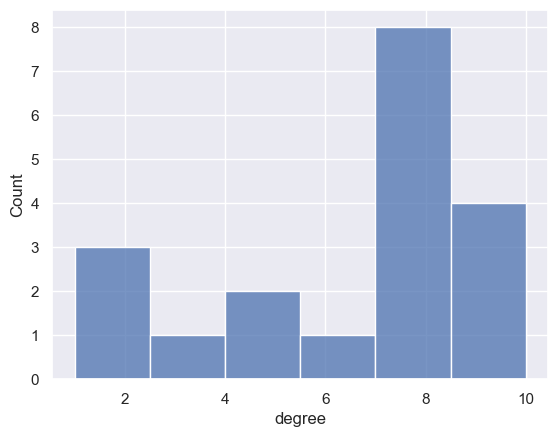

In [ ]:
view = g.window(0, 2)

# Find vertex with greatest degree in graph
ids = []
degrees = []
for v in view.vertices():
    ids.append(v.id())
    degrees.append(v.degree())

df = pd.DataFrame.from_dict({"id": ids,"degree": degrees})
sns.set()
sns.histplot(df.degree)
big_boss = df.loc[df['degree'].idxmax()]
print(big_boss)

Find more stats from your graph.

In [ ]:
# Graph and View have several functions to check information about a vertex
# Change value in brackets to id outputted in big_boss
print(g.has_vertex(4611686018370953727))
print(view.vertex(4611686018370953727).in_degree())
print(view.vertex(4611686018370953727).out_degree())
print(view.vertex(4611686018370953727).degree())

# Algorithms can be performed on a vertex to find e.g. triangle count
# Change value in brackets after "(view, )" to id outputted in big_boss
triangles  = algorithms.local_triangle_count(view, 4611686018370953727) # How many triangles is vertex involved in
print(triangles)

True
0
47
47
0
